# Python codes for [Introduction to Computional Stochastic PDEs, CUP 2014](http://www.cambridge.org/gb/academic/subjects/mathematics/differential-and-integral-equations-dynamical-systems-and-co/introduction-computational-stochastic-pdes?format=PB&isbn=9780521728522)

[T. Shardlow](http://people.bath.ac.uk/tjs42/) Dec 2015
# Chapter 6





In [2]:

from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
from builtins import (bytes, dict, int, list, object, range, str,
                      ascii, chr, hex, input, next, oct, open,
                      pow, round, super, filter, map, zip)
from future.builtins.disabled import (apply, cmp, coerce, execfile,
                                      file, long, raw_input, reduce, reload,
                                      unicode, xrange, StandardError)
#
import sys

In [3]:
from math import *
# Numpy
import numpy as np
from numpy import matlib
# Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# Scipy
import scipy
from scipy import sparse
from scipy.sparse import linalg
from scipy import optimize

The Fourier transform is important for stationary processes. We first work with the Fourier transform of sample paths.

In [4]:
import ch1
def spectral_density(X,T):
    """
    A6.1 Page 222
    """
    Uk,nu=ch1.get_coeffs(X,0,T)
    f=(np.abs(Uk) ** 2) * T / (2 * pi)
    return f,nu 
def icspde_dst1(u):
    return scipy.fftpack.dst(u,type=1,axis=0)/2

We sample white noise with $J=3200$ modes and plots its spectrum.

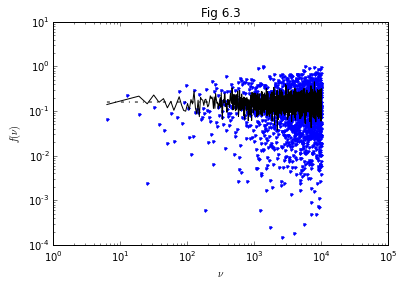

In [6]:
noSamples=10
J=3200;    dt=1/J
fc=np.zeros(J+2)
#    
for m in range(noSamples):
    sq_rt_lambda=sqrt(2);
    xi=np.random.randn(J+1)
    coeffs=sq_rt_lambda*xi
    y2=np.hstack([0,icspde_dst1(coeffs),0]);
    f,nu=spectral_density(y2,1)
    fc=fc+f
fc=fc/noSamples
poly=0*fc+1/(2*pi)
#
plt.loglog(nu,f,'b.')
plt.loglog(nu,fc,'k-')
plt.loglog(nu,poly,'k-.')
s=plt.xlabel(r'$\nu$')
s=plt.ylabel(r'$f(\nu)$')
s=plt.title(r'Fig 6.3')

Stationary processes can be written as a stochastic integral and here we use quadrature to generate sample paths from the integral representation. For the sinc covariance, this is particularly convenient.

In [9]:
def quad_sinc(t,J,ell):
    """
    A6.3 Page 235
    """
    R=pi / ell
    nustep=2 * R / J
    Z=(np.exp(- 1j * t * R) * np.dot(np.random.randn(2), [1j,1]) / sqrt(2)
       +np.sum(np.exp(1j * t * (- R + j * nustep)) * np.dot(np.random.randn(2),[1j,1]) for j in range(J-2))
       + np.exp(1j * t * R) * np.dot(np.random.randn(2) , [1j,1]) / sqrt(2))
    Z=Z * sqrt(ell / (2 * pi))
    return Z

We generate two sample paths with each call, by working with complex-valued processes.

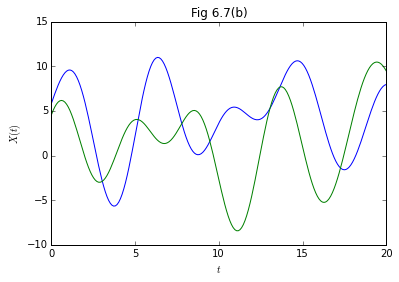

In [10]:
t=np.linspace(0,20,200)
Z=quad_sinc(t,100,2)
plt.plot(t,np.real(Z))
plt.plot(t,np.imag(Z))
s=plt.xlabel(r'$t$')
s=plt.ylabel(r'$X(t)$')
s=plt.title(r'Fig 6.7(b)')

For a general density function, more work is required. Here we show how to sample from the mean-zero stationary Gaussian process with the Whittle Matern covariance.

In [11]:
fft=np.fft.fft
fft2=np.fft.fft2
ifft=np.fft.ifft
#
def squad(T,N,M,fhandle):
    """
    A6.4 Page 239
    """
    dt=T / (N - 1);    t=np.linspace(0,T,N)
    R=pi / dt;    dnu=2 * pi / (N * dt * M)
    Z=np.zeros(N);    coeff=np.zeros(N,dtype='complex128')
    for m in range(M):
        for k in range(N):
            nu=- R + ((k - 1) * M + (m - 1)) * dnu
            xi=np.dot(np.random.randn(2),[1,1j])
            coeff[k]=sqrt(fhandle(nu) * dnu) * xi
            if ((m == 1 and k == 1) or (m == M and k == N)):
                coeff[k]=coeff[k] / sqrt(2)
        Zi=N *ifft(coeff)
        Z=Z + np.exp(1j * (- R + (m - 1) * dnu) * t)*Zi
    return t,Z

def interp_quad(s,N,M,fhandle):
    """
    A6.6 Page 240
    """
    T=np.max(s) - np.min(s)
    t,Z=squad(T,N,M,fhandle)
    Zr=np.real(Z);    X=np.interp(s,t + np.min(s),Zr)
    Zi=np.imag(Z);    Y=np.interp(s,t + np.min(s),Zi)
    return X,Y

def quad_wm(s,N,M,q):
    """
    A6.7 Page 241
    """
    X,Y=interp_quad(s,N,M,lambda nu: f_wm(nu,q))
    return X,Y
from numba import jit, float64
@jit([float64(float64,float64)])
def f_wm(nu,q):
    """
    A6.7 helper function that gives WM spectral density
    """        
    const=gamma(q + 0.5) / (gamma(q) * gamma(0.5))
    f=const / ((1 + nu * nu) ** (q + 0.5))
    return f

The Whittle-Matern covariance has a regularity parameter $q$. Here we show the effects of changing this parameter.

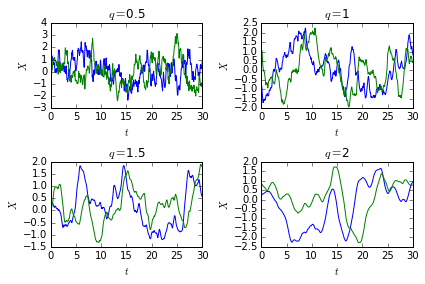

In [12]:
T=30;    N=2**9
t=np.linspace(0,T,N)
M=N/4
vector_q=[0.5,1,1.5,2]
for i in range(1,5):
    q=vector_q[i-1]
    X,Y=quad_wm(t,N,M,q)
    plt.subplot(2,2,i)
    plt.plot(t,X)
    plt.plot(t,Y)
    s=plt.title('$q=$'+str(q))
    s=plt.xlabel(r'$t$')
    s=plt.ylabel(r'$X$')
plt.tight_layout() 
# Fig 6.6

Here's a simple example for sampling Gaussian distributions with circulant covariance matrices

In [15]:
def circ_cov_sample(c):
    """
    A6.7 Page 246
    """
    N=c.size;    d=ifft(c) * N
    xi=np.dot(np.random.randn(N,2), [1,1j])
    Z=fft(np.multiply(d ** 0.5,xi)) / sqrt(N)
    X=np.real(Z);    Y=np.imag(Z)
    return X,Y


In [16]:
[x,y]=circ_cov_sample(np.array([3,2,1,2]))
print("x=",x,"\n y=",y)

x= [-0.01470587 -1.06910821 -1.46842303 -0.41402069] 
 y= [ 0.14296393 -0.82700282 -1.67522635 -0.7052596 ]


In general, stationary covariance matrices need to be embedded into circulant matrices, to develop sampling with the Fourier transform.

In [17]:
def circulant_embed_sample(c):
    """
    A6.8 Page 247
    """
    # create first column of C_tilde
    tilde_c=np.hstack([c,c[-2:0:-1]])
    # obtain 2 samples from N(0,C_tilde)
    X,Y=circ_cov_sample(tilde_c)
    # extract samples from N(0,C)
    N=c.size;    X=X[0:N];    Y=Y[0:N]
    return X,Y

Here's an example with the exponential covariance function.

In [18]:
[x,y]=circulant_embed_sample(np.array([5,2,3,4]))
print("x=",x,"\n y=",y)

x= [ 0.84251047 -0.36799683 -0.00531596  1.80668036] 
 y= [-3.78779808 -0.84449388 -0.54988244 -2.56054302]


In [19]:
def circulant_exp(N,dt,ell):
    """
    A6.9 Page 248
    """
    t=np.arange(N)*dt; 
    c=np.exp(- np.abs(t) / ell)
    X,Y=circulant_embed_sample(c)
    return t,X,Y# deleted last return value c


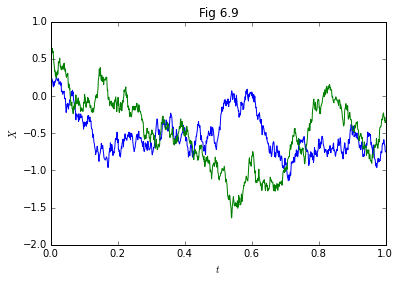

In [20]:
N=int(1e3)
dt=1/(N-1)
t,X,Y=circulant_exp(N,dt,1)
plt.plot(t,X)
plt.plot(t,Y)
s=plt.xlabel(r'$t$')
s=plt.ylabel(r'$X$')
s=plt.title(r'Fig 6.9')

Now, we can sample from stationary Gaussian process with exponential covariance. We compute its spectral density from the sample paths.

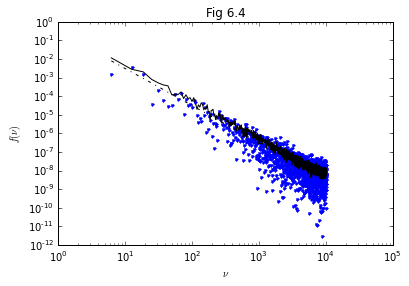

In [21]:
noSamples=10
J=3200;    dt=1/J
fc=np.zeros(J)
for m in range(noSamples):
    t,X,Y=circulant_exp(J+1,dt,1)
    f,nu=spectral_density(X,1)
    fc=fc+f
fc=fc/noSamples
poly=(1/pi)/(1+nu**2)
plt.figure(1)
plt.loglog(nu,f,'b.')
plt.loglog(nu,fc,'k-')
plt.loglog(nu,poly,'k-.')
s=plt.xlabel(r'$\nu$')
s=plt.ylabel(r'$f(\nu)$')
s=plt.title(r'Fig 6.4')

In many cases, the circulant embedding is not positive definite and the circulant embedding needs to be used approximately.

In [22]:
def circulant_embed_approx(c):
    """
    A6.10 Page 251
    """
    tilde_c=np.hstack([c,c[-2:0:-1]])
    tilde_N=tilde_c.size
    d=np.real(ifft(tilde_c)) * tilde_N
    d_minus=np.maximum(- d,0)
    d_pos=np.maximum(d,0)
    if (np.max(d_minus) > 0):
        print('rho(D_minus)={x:0.5g}'.format(x=np.max(d_minus)))
    xi=np.dot(np.random.randn(tilde_N,2), [1,1j])
    Z=fft(np.multiply(d_pos ** 0.5,xi)) / sqrt(tilde_N)
    N=c.size;    X=np.real(Z[0:N]);    Y=np.imag(Z[0:N])
    return X,Y

def circulant_wm(N,M,dt,q):
    """
    A6.11 Page 252
    """
    Ndash=N + M - 1
    c=np.zeros(Ndash + 1)
    T=(Ndash+1)*dt;    t=np.linspace(0,T,Ndash+1)
    c[0]=1 # t=0 is special, due to singularity in Bessel fn
    const=2 ** (q - 1) * gamma(q)
    for i in range(1,Ndash + 1):
        c[i]=(t[i] ** q) * scipy.special.kv(q,t[i]) / const
    X,Y=circulant_embed_approx(c)
    X=X[0:N];    Y=Y[0:N];    t=t[0:N]
    return t,X,Y,c

In [13]:
N=100; M=9900; dt=1/(N-1)
t,X,Y,c=circulant_wm(N,M,dt,3)
    

rho(D_minus)=3.8058e-14


Here we notice that the spectral radius of the negative part of matrix $D$ of eigenvalues is non-zero. It is small in this case and leads to a small error when neglected.